# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Functions

In [2]:
import glob

def find_calibration_parameters(calibration_dir):
    # prepare object points
    nx = 9
    ny = 6

    objectPoints = []
    imagePoints  = []
    
    objP = np.zeros((9*6,3),np.float32)
    objP[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    #find the files and iterate over them
    files = glob.glob(calibration_dir+"calibration*.jpg")
    
    fig = plt.figure(figsize=(20, 10))
    count = 0
    for file in files:
        
        #increment the count
        count+=1
        
        #print(file)
        img = cv2.imread(file)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
       # If found, draw corners
        if ret == True:
            imagePoints.append(corners)
            objectPoints.append(objP)
            
            #Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            ax = fig.add_subplot(5, 4, count)
            ax.imshow(img)
        else:
            ax = fig.add_subplot(5, 4, count)
            ax.imshow(np.zeros(img.shape))
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, gray.shape[::-1], None, None)
    return mtx, dist
        


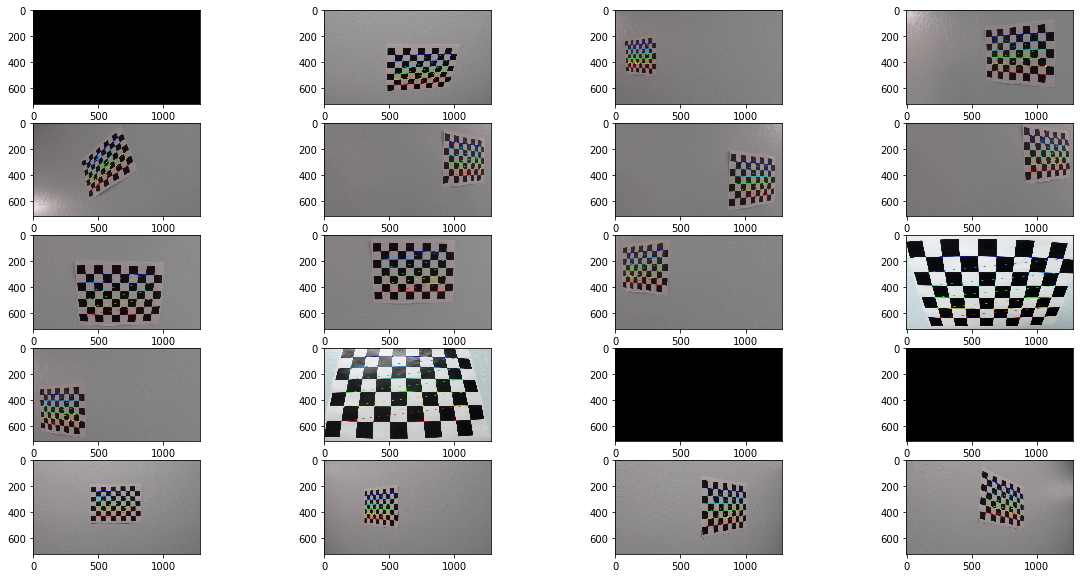

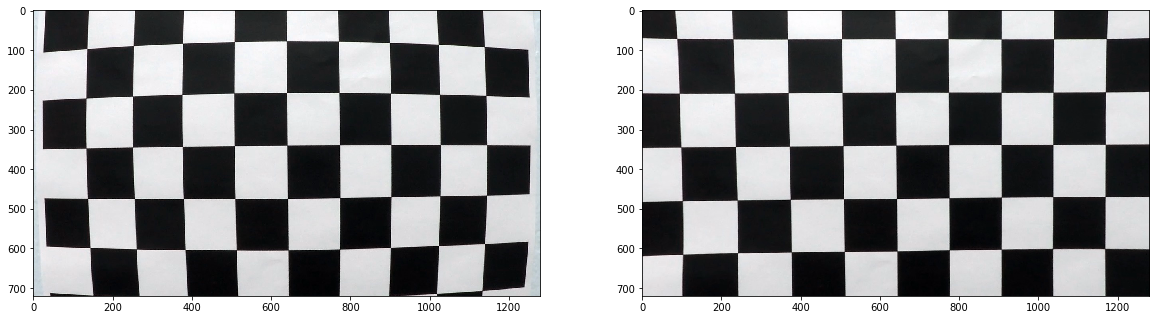

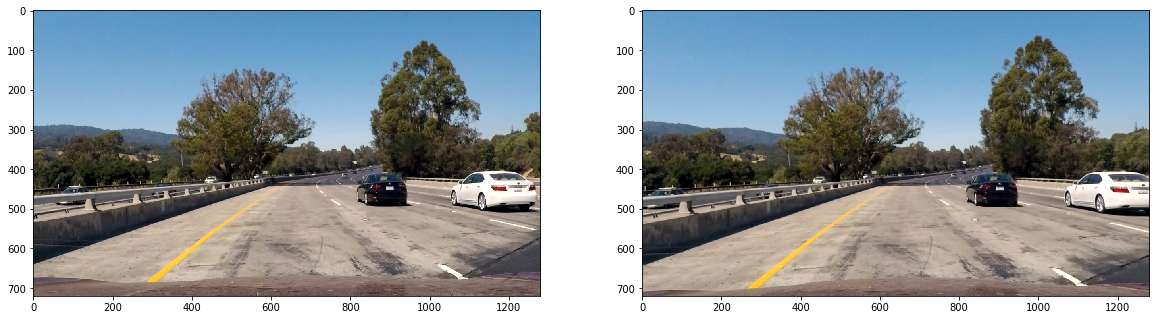

In [3]:
# Get the camera calibration paramters
mtx, dist = find_calibration_parameters('./camera_cal/')

img = cv2.imread('./camera_cal/calibration1.jpg')
undst = cv2.undistort(img, mtx, dist, None, mtx)
 
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(undst)

img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undst = cv2.undistort(img, mtx, dist, None, mtx)
 
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(undst)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def warp_perspective(img):
    # Perspective Transform
    src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
    dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = img.shape
    warped = cv2.warpPerspective(img, M, img_size[1::-1], flags=cv2.INTER_LINEAR)
    return warped, M, Minv

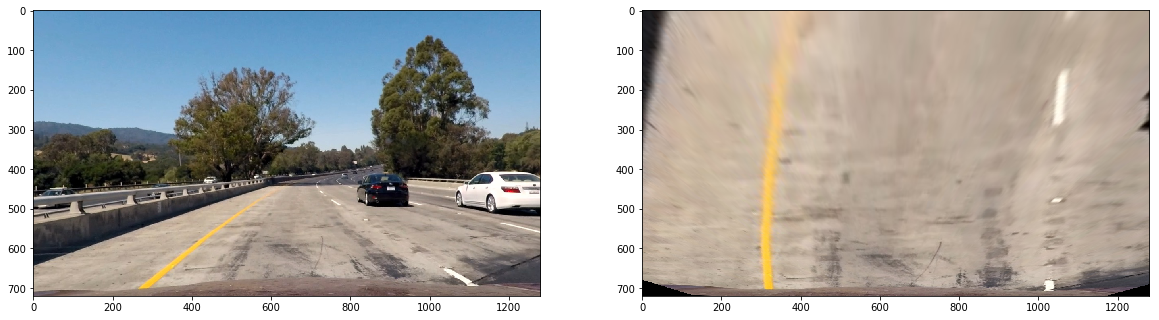

In [6]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undst = cv2.undistort(img, mtx, dist, None, mtx)
lane_persp_view,M,Minv = warp_perspective(img)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(undst)
plt.subplot(122)
plt.imshow(lane_persp_view)

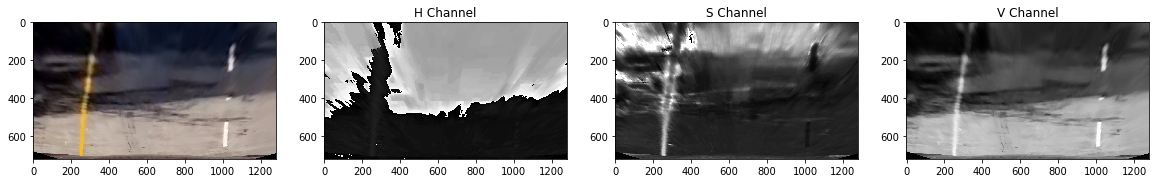

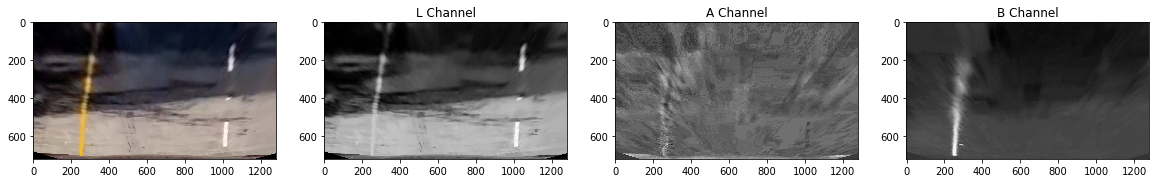

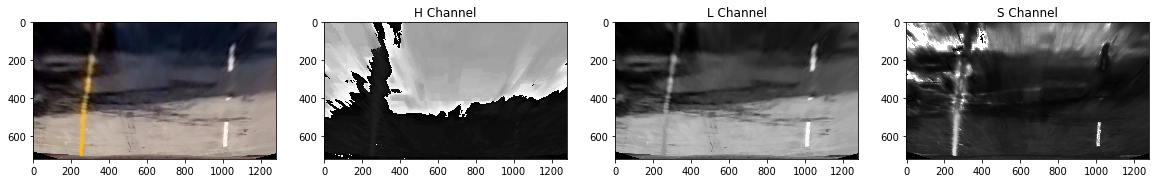

In [7]:
import cv2 

def plot_color_space(img, colorspace):
    
    color_t = getattr(cv2, 'COLOR_RGB2{}'.format(colorspace))
    resImage = cv2.cvtColor(img, color_t)
    
    plt.figure(figsize=(20, 10))
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    plt.imshow(resImage[:,:,0],cmap='gray')
    plt.title('{} Channel'.format(colorspace[0]))
    plt.subplot(143)
    plt.imshow(resImage[:,:,1],cmap='gray')
    plt.title('{} Channel'.format(colorspace[1]))
    plt.subplot(144)
    plt.imshow(resImage[:,:,2],cmap='gray')
    plt.title('{} Channel'.format(colorspace[2]))
    

# Read in and grayscale the image
image = mpimg.imread('test_images/test5.jpg')

#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lane_persp_view,M,Minv = warp_perspective(image)
        
plot_color_space(lane_persp_view,'HSV')
plot_color_space(lane_persp_view,'LAB')
plot_color_space(lane_persp_view,'HLS')


In [8]:
def threshold_color_space(img,colorspace,channel,threshold,cliplimit=2,plot_images=0):
    color_t = getattr(cv2, 'COLOR_RGB2{}'.format(colorspace))
    resImage = cv2.cvtColor(img, color_t)
    selectChannel = resImage[:,:,channel]
    
    # Normalize regions of the image using CLAHE
    clahe = cv2.createCLAHE(cliplimit, tileGridSize=(8, 8))
    norm_img = clahe.apply(selectChannel)
 
    # Threshold to binary
    ret, binary = cv2.threshold(norm_img, threshold, 1, cv2.THRESH_BINARY)
    
    # Adaptive threshold
    # binary = cv2.adaptiveThreshold(norm_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #        cv2.THRESH_BINARY,51,-20)
    
    if plot_images:
        plt.figure(figsize=(20, 10))
        plt.subplot(141)
        plt.imshow(img)
        plt.subplot(142)
        plt.imshow(selectChannel,cmap='gray')
        plt.title('{} Channel'.format(colorspace[channel]))
        plt.subplot(143)
        plt.imshow(norm_img,cmap='gray')
        plt.title('Normalized channel')
        plt.subplot(144)
        plt.imshow(binary,cmap='gray')
        plt.title('Thresholded result')

        
    return binary

def find_lane_pixels(img, plot_images=0):

    # Perform binary thresholding according to each setting and combine them into one image.
    scores = np.zeros(img.shape[0:2]).astype('uint8')
    #scores += threshold_color_space(img,'HSV',2,230,plot_images=plot_images)
    scores += threshold_color_space(img,'LAB',2,150,plot_images=plot_images)
    scores += threshold_color_space(img,'HLS',1,180,plot_images=plot_images)
 
    result = cv2.normalize(scores, None, 0, 255, cv2.NORM_MINMAX)
    
    if plot_images:
        plt.figure(figsize=(20, 10))
        plt.subplot(141)
        plt.imshow(img)
        plt.subplot(142)
        plt.imshow(result,cmap='gray')
        plt.title('Lane pixels')

 
    return result

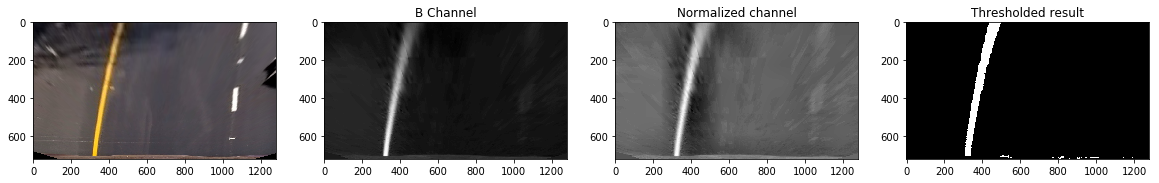

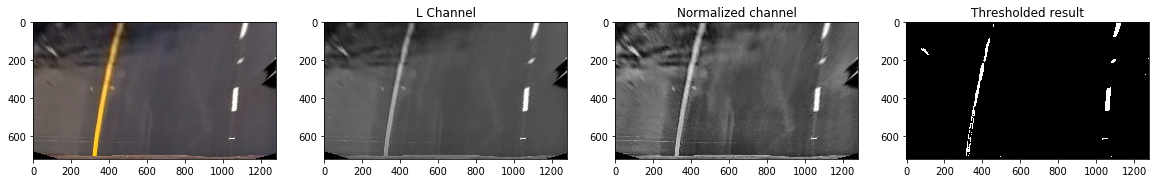

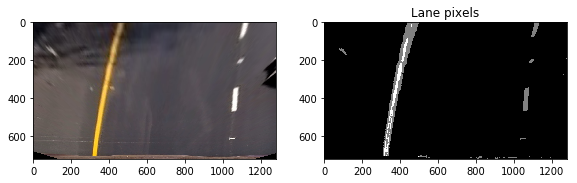

In [9]:
# Read in and grayscale the image
image = mpimg.imread('test_images/test6.jpg')

# conver to the overhead view
lane_persp_view,M,Minv = warp_perspective(image)
        
#get the lane pixels
lane_pixels = find_lane_pixels(lane_persp_view,1)

   

## Build the Lane Finding Pipeline

In [10]:
class DetectLane:
    def __init__(self):
        self.mtx = []
        self.left_fit_gl=[]
        self.right_fit_gl=[]
        self.leftrad = []
        self.rightrad = []
        self.leftLaneEndingBot = []
        self.leftLaneEndingTop = []
        self.rightLaneEndingBot = []
        self.rightLaneEndingTop = []
        self.leftBotDash = []
        self.rightBotDash =[]
        self.bottomOffset = 10
        self.lineEndTol = 100
        self.curvTol    = 1000
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.left_fitx = []
        self.right_fitx = []
        self.alpha = 0.2
        

    def set_calibration_matrix(self,mtx):
        self.mtx = mtx
        return
    
    def warp_perspective(self,img):
        # Perspective Transform
        src = np.float32([(200, 720), (580, 480), (720, 480), (1050, 700)])
        dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        img_size = img.shape
        warped = cv2.warpPerspective(img, M, img_size[1::-1], flags=cv2.INTER_LINEAR)
        return warped, M, Minv

    def threshold_color_space(self,img,colorspace,channel,threshold,cliplimit=2,plot_images=0):
        color_t = getattr(cv2, 'COLOR_RGB2{}'.format(colorspace))
        resImage = cv2.cvtColor(img, color_t)
        selectChannel = resImage[:,:,channel]

        # Normalize regions of the image using CLAHE
        clahe = cv2.createCLAHE(cliplimit, tileGridSize=(8, 8))
        norm_img = clahe.apply(selectChannel)

        # Threshold to binary
        ret, binary = cv2.threshold(norm_img, threshold, 1, cv2.THRESH_BINARY)

        # Adaptive threshold
        # binary = cv2.adaptiveThreshold(norm_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        #        cv2.THRESH_BINARY,51,-20)

        if plot_images:
            plt.figure(figsize=(20, 10))
            plt.subplot(141)
            plt.imshow(img)
            plt.subplot(142)
            plt.imshow(selectChannel,cmap='gray')
            plt.title('{} Channel'.format(colorspace[channel]))
            plt.subplot(143)
            plt.imshow(norm_img,cmap='gray')
            plt.title('Normalized channel')
            plt.subplot(144)
            plt.imshow(binary,cmap='gray')
            plt.title('Thresholded result')


        return binary

    def find_lane_pixels(self,img, plot_images=0):

        # Perform binary thresholding according to each setting and combine them into one image.
        scores = np.zeros(img.shape[0:2]).astype('uint8')
        #scores += threshold_color_space(img,'HSV',2,230,plot_images=plot_images)
        scores += threshold_color_space(img,'LAB',2,150,plot_images=plot_images)
        scores += threshold_color_space(img,'HLS',1,210,plot_images=plot_images)

        result = cv2.normalize(scores, None, 0, 255, cv2.NORM_MINMAX)

        if plot_images:
            plt.figure(figsize=(20, 10))
            plt.subplot(141)
            plt.imshow(img)
            plt.subplot(142)
            plt.imshow(result,cmap='gray')
            plt.title('Lane pixels')
            
        return result

    def find_lanes(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        startY = np.int(binary_warped.shape[0]*1/2)
        histogram = np.sum(binary_warped[startY:,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines

        midpoint = np.int(histogram.shape[0]/2)
        startX = np.int(binary_warped.shape[1]*0.1)
        leftx_base = np.argmax(histogram[startX:midpoint])+startX
        rightx_base = np.argmax(histogram[midpoint:binary_warped.shape[1]-startX]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
            else:
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,255), 2)
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2)
            else:
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,255), 2)
            

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

         # Fit a second order polynomial to each
        left_fit=[]
        right_fit=[]
        if np.any(lefty) and np.any(leftx):
            left_fit = np.polyfit(lefty, leftx , 2)

        if np.any(righty) and np.any(rightx):    
            right_fit = np.polyfit(righty, rightx , 2)

        #Put the detected lane points in the output image
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        #Put the fitted lanes in the output image
        ploty = np.linspace(0, 719, num=720)
        for y in ploty:
            xLeft = np.int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
            xRight = np.int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
            if xLeft>=0 and xLeft<binary_warped.shape[1]:
                out_img[np.int(y),xLeft,:]  = [255, 255, 0]
            if xRight>=0 and xRight<binary_warped.shape[1]:
                out_img[np.int(y),xRight,:] = [255, 255, 0]
        
        return out_img.astype(np.uint8),left_fit,right_fit, leftx, lefty, rightx, righty


    def find_lanes_tracking(self,binary_warped,left_fit,right_fit):

        #print("Inside lanes tracking")

        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 50
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

         # Fit a second order polynomial to each
        left_fit=[]
        right_fit=[]
        left_fitx =[]
        right_fitx=[]
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        if np.any(lefty) and np.any(leftx):
            left_fit = np.polyfit(lefty, leftx , 2)
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if np.any(righty) and np.any(rightx):    
            right_fit = np.polyfit(righty, rightx , 2)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, 719, num=720)
        if np.any(left_fitx):
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            for y in ploty:
                xLeft = np.int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
                if xLeft>=0 and xLeft<binary_warped.shape[1]:
                    out_img[np.int(y),xLeft,:]  = [255, 255, 0]
       
            
        if np.any(right_fitx):    
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            for y in ploty:
                xRight = np.int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
                if xRight>=0 and xRight<binary_warped.shape[1]:
                    out_img[np.int(y),xRight,:] = [255, 255, 0]
        
        
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        #Put the fitted lanes in the output image
        
        

        return result.astype(np.uint8),left_fit,right_fit, leftx, lefty, rightx, righty

    def get_curvature(self,xpoints, ypoints):

        # Get conversions in x and y from pixels space to meters
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix

        ploty = np.linspace(0, 719, num=720)

        # Fit a second order polynomial to each
        fit_cr = np.polyfit(ypoints*ym_per_pix, xpoints*xm_per_pix , 2)

        y_eval = np.max(ploty)
        # Calculate the new radii of curvature
        curverad =  ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

        return curverad
   
    def get_position(self, x_bot_left,x_bot_right,shape):
        # Get conversions in x and y from pixels space to meters
        ym_per_pix = self.ym_per_pix
        xm_per_pix = self.xm_per_pix

        left_bot_x = x_bot_left*xm_per_pix
        right_bot_x = x_bot_right*xm_per_pix
        offset = shape[1]/2*xm_per_pix - (left_bot_x+right_bot_x)/2
        return offset
        
        
    def create_result_image(self,undist,warped,left_fitx,right_fitx,M,Minv):
        height = undist.shape[0]-self.bottomOffset
        ploty = np.linspace(0, height-1, num=height)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        #for debugging
        #undistWarp = cv2.warpPerspective(undist, M, (image.shape[1], image.shape[0])) 
        #result = cv2.addWeighted(undistWarp, 1, color_warp, 0.3, 0)
        return result


    def create_composite_image(self,img, lane_img, lane_persp_view, lane_track_img):
        img_size = img.shape
        result   = np.zeros([np.int(img_size[0]*3/2),img_size[1],img_size[2]])

        result[np.int(img_size[0]/2):np.int(img_size[0]*3/2),:,:] = img
        resX = np.int(img_size[1]/3)
        resY = np.int(img_size[0]/2)

        #resized_image = cv2.resize(lane_img, (resX, resY)) 
        #left_top = np.dstack((resized_image,resized_image,resized_image))
        #result[0:resY,0:resX,:] = left_top.astype(np.uint8)

        left_top = cv2.resize(lane_img, (resX, resY)) 
        result[0:resY,0:resX,:] = left_top.astype(np.uint8)

        resized_image = cv2.resize(lane_persp_view, (resX, resY)) 
        middle_top = np.dstack((resized_image,resized_image,resized_image))
        result[0:resY,resX:2*resX,:] = middle_top.astype(np.uint8)

        resXNew = img_size[1]-2*resX
        right_top = cv2.resize(lane_track_img,(resXNew,resY))
        result[0:resY,2*resX:img_size[1],:] = right_top

        return result.astype(np.uint8)

    
    def process_image(self, image):
        # Undistort the image
        image_undst = cv2.undistort(image, self.mtx, dist, None, mtx)

        #Define a kernel size and apply Gaussian smoothing
        #kernel_size = 5
        #blur_image = self.gaussian_blur(image_undst,kernel_size)
        blur_image = image_undst
        
        lane_persp_view,M,Minv = self.warp_perspective(blur_image)
        lane_persp_view_seg  =  self.find_lane_pixels(lane_persp_view)
        
        if np.any(self.left_fit_gl):
            out_img,left_fit,right_fit,leftx, lefty, rightx, righty = self.find_lanes_tracking(lane_persp_view_seg,self.left_fit_gl,self.right_fit_gl)
        else:
            out_img,left_fit,right_fit,leftx, lefty, rightx, righty = self.find_lanes(lane_persp_view_seg)

        #out_img,left_fit,right_fit,leftx, lefty, rightx, righty = self.find_lanes(lane_persp_view_seg)
    
        dashy = image.shape[0]
        if np.any(left_fit):
            ploty = np.linspace(0, lane_persp_view_seg.shape[0]-self.bottomOffset-1, lane_persp_view.shape[0]-self.bottomOffset )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            left_bot_x = left_fitx[-1]
            left_top_x = left_fitx[0]
            left_bot_dash = left_fit[0]*dashy**2 + left_fit[1]*dashy + left_fit[2]
            leftrad = self.get_curvature(leftx, lefty) 
            
            #print("Left:",abs(self.leftrad-leftrad))
            if self.leftLaneEndingBot:
                if abs(left_bot_x-self.leftLaneEndingBot)<self.lineEndTol and abs(left_top_x-self.leftLaneEndingTop)<self.lineEndTol :
                    self.leftLaneEndingBot = left_bot_x
                    self.leftLaneEndingTop = left_top_x
                    self.left_fit_gl = left_fit
                    self.leftrad = leftrad   
                    self.leftBotDash = left_bot_dash
            else:
                self.leftLaneEndingBot = left_bot_x
                self.leftLaneEndingTop = left_top_x
                self.left_fit_gl = left_fit
                self.leftrad = leftrad   
                self.leftBotDash = left_bot_dash
        
        if np.any(right_fit):
            ploty = np.linspace(0, lane_persp_view_seg.shape[0]-self.bottomOffset-1, lane_persp_view_seg.shape[0]-self.bottomOffset )
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            right_bot_x = right_fitx[-1]
            right_top_x = right_fitx[0]
            rightrad = self.get_curvature(rightx, righty) 
            right_bot_dash = right_fit[0]*dashy**2 + right_fit[1]*dashy + right_fit[2]
            
            #print("Right:",right_bot_x)
            if self.rightLaneEndingBot:
                if abs(right_bot_x-self.rightLaneEndingBot)<self.lineEndTol and abs(right_top_x-self.rightLaneEndingTop)<self.lineEndTol :
                    self.rightLaneEndingBot = right_bot_x
                    self.rightLaneEndingTop = right_top_x
                    self.right_fit_gl = right_fit
                    self.rightrad = rightrad 
                    self.rightBotDash = right_bot_dash
            else:
                self.rightLaneEndingBot = right_bot_x
                self.rightLaneEndingTop = right_top_x
                self.right_fit_gl = right_fit
                self.rightrad = rightrad
                self.rightBotDash = right_bot_dash
        
        #print(self.left_fit_gl)
        
        #Get the lane fits for the current image
        ploty = np.linspace(0, lane_persp_view.shape[0]-self.bottomOffset-1, lane_persp_view.shape[0]-self.bottomOffset )
        left_fitx = self.left_fit_gl[0]*ploty**2 + self.left_fit_gl[1]*ploty + self.left_fit_gl[2]
        right_fitx = self.right_fit_gl[0]*ploty**2 + self.right_fit_gl[1]*ploty + self.right_fit_gl[2]
        
        
        #if any(self.left_fitx):
        #    l1 = [self.alpha*x for x in self.left_fitx]
        #    l2 = [(1-self.alpha)*x for x in self.left_fitx] 
        #    self.left_fitx = np.array(l1)+np.array(l2)
        #else:
        #    self.left_fitx = np.array(left_fitx)
        #    self.right_fitx = np.array(right_fitx)
            
        
        #Create the result image
        result = self.create_result_image(image_undst,lane_persp_view_seg,left_fitx,right_fitx,M,Minv)
        compImage = self.create_composite_image(result, lane_persp_view, lane_persp_view_seg, out_img)
        self.offset = self.get_position(self.leftBotDash,self.rightBotDash,result.shape)
        
        return compImage, self.leftrad, self.rightrad, self.offset

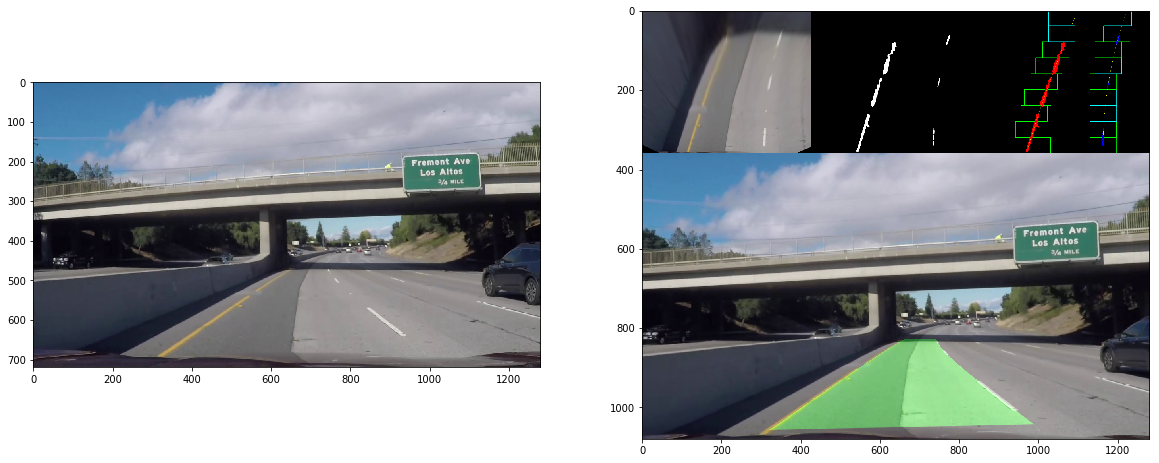

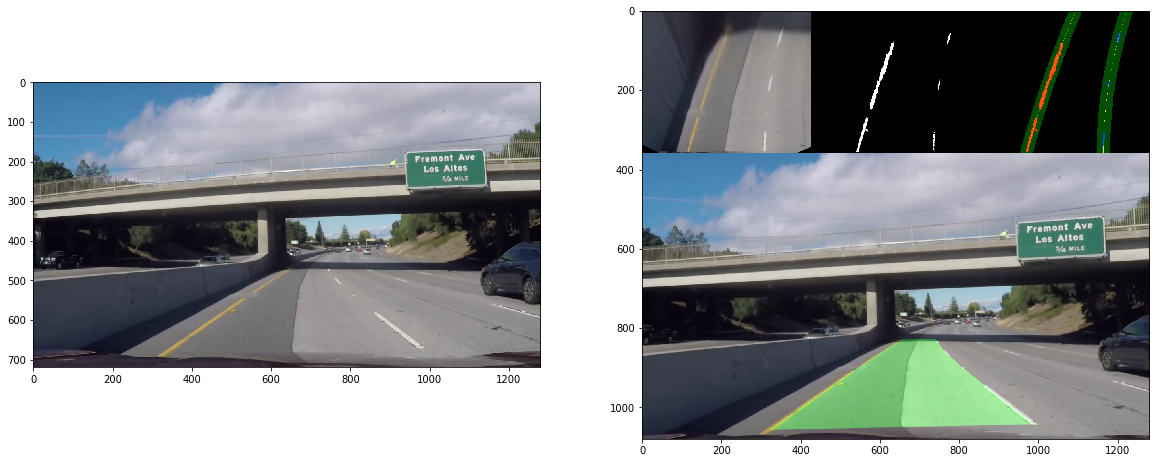

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 

cap = cv2.VideoCapture('challenge_video.mp4')
det = DetectLane()
det.set_calibration_matrix(mtx)

# Read in and grayscale the image
#image = mpimg.imread('test_images/straight_lines2.jpg')

count = 0
success = True
while success:
    success,frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    count = count+1
    if count>=100:
        result, leftrad, rightrad, offset = det.process_image(frame)
       
         
        plt.figure(figsize=(20, 10))
        plt.subplot(121)
        plt.imshow(frame)
        plt.subplot(122)
        plt.imshow(result)
        if count==101:
            break
                
cap.release()

## Project Video

In [19]:
import numpy as np
import cv2


cap = cv2.VideoCapture('project_video.mp4')
test_output = 'test_videos_output/project_video_output_debug.mp4'

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(test_output,fourcc, 20.0, (1280,1080),True)

#instantiate the detection object
det = DetectLane()
det.set_calibration_matrix(mtx)

count = 0
success = True
while success:
    success,frame = cap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result, leftrad, rightrad, offset = det.process_image(frame)
        
        outString = "Curvature:{0:5} km".format((np.int(leftrad)+np.int(rightrad))/2000)
        cv2.putText(img = result, text = outString, org = (50,400), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
                    fontScale = 1,color = (255, 255, 0))
        outString = "Position  :{0:1.2f} cm".format(offset*100)
        cv2.putText(img = result, text = outString, org = (50,450), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
                    fontScale = 1,color = (255, 255, 0))
       
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        out.write(result)
    
    count = count+1
    
    print('.', end='', flush=True)
    if count%100 == 0:
        print(count)
                
cap.release()
out.release()
cv2.destroyAllWindows()

....................................................................................................100
....................................................................................................200
....................................................................................................300
....................................................................................................400
....................................................................................................500
....................................................................................................600
....................................................................................................700
....................................................................................................800
....................................................................................................900
................................................................

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

Now for the challenge video

In [16]:
import numpy as np
import cv2

cap = cv2.VideoCapture('challenge_video.mp4')
test_output = 'test_videos_output/challenge_video_output_debug.mp4'

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(test_output,fourcc, 20.0, (1280,1080),True)

#instantiate the detection object
det = DetectLane()
det.set_calibration_matrix(mtx)

count = 0
success = True
while success:
    success,frame = cap.read()
    if success:
        
        #if count < 110 or count > 150:
        #    count = count+1
        #    continue
        
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result, leftrad, rightrad, offset = det.process_image(frame)
        
        #print("Frmae number:",count+1)
        outString = "Curvature:{0:5} km".format((np.int(leftrad)+np.int(rightrad))/2000)
        cv2.putText(img = result, text = outString, org = (50,400), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
                    fontScale = 1,color = (255, 255, 0))
        outString = "Position  :{0:1.2f} cm".format(offset*100)
        cv2.putText(img = result, text = outString, org = (50,450), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
                    fontScale = 1,color = (255, 255, 0))
        #outString = "Frame Num :{0:3d}".format(count+1)
        #cv2.putText(img = result, text = outString, org = (50,500), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
        #            fontScale = 1,color = (255, 255, 0))
        
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        out.write(result)
    
    count = count+1
    print('.', end='', flush=True)
    if count%100 == 0:
        print(count)

cap.release()
out.release()
cv2.destroyAllWindows()

....................................................................................................100
....................................................................................................200
....................................................................................................300
....................................................................................................400
..................................................................................

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('harder_challenge_video.mp4')
test_output = 'test_videos_output/harder_challenge_video_output.mp4'

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(test_output,fourcc, 20.0, (1280,1080),True)

#instantiate the detection object
det = DetectLane()
det.set_calibration_matrix(mtx)

count = 0
success = True
while success:
    success,frame = cap.read()
    if success:
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result, leftrad, rightrad, offset = det.process_image(frame)
        
        #print("Frmae number:",count+1)
        outString = "Curvature:{0:5} km".format((np.int(leftrad)+np.int(rightrad))/2000)
        cv2.putText(img = result, text = outString, org = (50,400), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
                    fontScale = 1,color = (255, 255, 0))
        outString = "Position  :{0:1.2f} cm".format(offset*100)
        cv2.putText(img = result, text = outString, org = (50,450), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
                    fontScale = 1,color = (255, 255, 0))
        outString = "Frame Num :{0:3d}".format(count+1)
        cv2.putText(img = result, text = outString, org = (50,500), fontFace = cv2.FONT_HERSHEY_TRIPLEX , 
                    fontScale = 1,color = (255, 255, 0))
        
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        out.write(result)
    
    count = count+1
    print('.', end='', flush=True)
    if count%100 == 0:
        print(count)

cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))